## Imports

In [1]:
import requests, pickle, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from bs4 import BeautifulSoup
from netwulf import visualize

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
cpu_count()

16

# Week 1

In [2]:

link = "https://ic2s2-2023.org/program"
r = requests.get(link)
soup = BeautifulSoup(r.content)

researchers = set()
for link in soup.find_all("a"):
    if "keynote -" in link.getText().lower():
        researchers.add(link.getText().split("- ")[-1].title())
for i in soup.find_all("i"):
    # print(i.text)
    names = i.text.lower().replace("chair: ","")#.replace("<u>","").replace("</u>","")
    # print(names)
    for name in names.split(","):
        researchers.add(name.strip().title())
    # researchers.update(names.split(""))

researchers = sorted(researchers)
with open('list_researchers.pickle', 'wb') as handle:
    pickle.dump(researchers, handle)

# Week 2

In [3]:
# url
base_url   = "https://api.openalex.org/authors"
version    = ""
resource   = "?search="
parameters = None
search_url = base_url + version + resource
# print(search_url)

# retrieve researchers
with open('list_researchers.pickle', 'rb') as handle:
    researchers = pickle.load(handle)
# print("N researchers:",len(researchers))

data = []
for r in tqdm(researchers):
    query = search_url + r.lower()
    results = requests.get(query).json()["results"]

    # no hit
    if results == []:
        # print(True,)
        # try removing middle name
        if len(r_:=r.lower().split()) > 2:
            query = search_url + r_[0] + " " + r_[-1]
            results = requests.get(query).json()["results"]
            # if no hit again, skip
            if results == []: continue
        else: # skip researcher
            continue
    
    try: # debugging
        # choose researcher with highest h-index
        bi,bh = -1,-1
        for i,r in enumerate(results):
            h = r["summary_stats"]["h_index"]
            if h > bh:
                bi = i
                bh = h
        # get info
        if results[bi]["last_known_institution"] != None:
            lcc = results[bi]["last_known_institution"]["country_code"]
        else: 
            lcc = None
        info = {
            "display_name":results[bi]["display_name"],
            "id":results[bi]["id"],
            "h_index":results[bi]["summary_stats"]["h_index"],
            "works_count":results[bi]["works_count"],
            "works_api_url":results[bi]["works_api_url"],
            "last_country_code":lcc,
        }
    except:
        print(query,bi,results)
        break
    data.append(info)
    # print(data)
    # break
researchers_df = pd.DataFrame(data).drop_duplicates(subset="id")
researchers_df["id"] = researchers_df["id"].str.replace("https://openalex.org/","",regex=True)
researchers_df = researchers_df.sort_values(by="display_name").reset_index(drop=True)
researchers_df.to_pickle("df_researchers.pickle")
researchers_df

"results/id"
"results/display_name"
"results/works_api_url"
"results/summary_stats/h_index"
"results/works_count"

# Troubles
# - calculate h-index?
# - data is null

100%|██████████| 1488/1488 [13:53<00:00,  1.78it/s]


'results/works_count'

# Week 3
### Ex 1

In [4]:
researchers_df = pd.read_pickle("df_researchers.pickle")
researchers_dfm = researchers_df[(5<=researchers_df.works_count) & (researchers_df.works_count<=5000)]

url = "https://api.openalex.org/works?filter=author.id:"
filters = """
,cited_by_count:>10
&select=id,publication_year,cited_by_count,authorships,title,abstract_inverted_index,concepts
&per-page=200
&cursor=""".replace("\n","")

data = []
for i in tqdm(range(0,len(researchers_dfm),25)):
    query = url + "|".join(researchers_dfm.id.iloc[i:i+25]) + filters
    
    cursor = "*"
    # print(query+cursor)
    while True: # paginating
        meta,results,_ = requests.get(query+cursor).json().values()
        # check if empty page
        if (cursor := meta["next_cursor"]) == None: break
        
        # loop results
        for w in results:
            # filter co-author count
            if len(w["authorships"]) > 9:
                continue
            
            # filter concepts
            accept_level = [False,False]
            for concept in w["concepts"]:
                if concept["level"] == 0:
                    if concept["display_name"].lower() in ["sociology","psychology","economics","political science"]:
                        accept_level[0] = True
                    if concept["display_name"].lower() in ["mathematics","physics","computer science"]:
                        accept_level[1] = True
            if not all(accept_level):
                # print(accept_level)
                continue
            
            # extract info
            del w["concepts"]
            author_ids = []
            for authors in w["authorships"]:
                author_ids.append(authors["author"]["id"].replace("https://openalex.org/",""))
            del w["authorships"]
            w["author_ids"] = author_ids
            data.append(w)
    # break



# """
# ic2s2 paper:
#     *id
#     *publication_year
#     *cited_by_count
#     *author_ids
# ic2s2 abstract:
#     *id
#     *title
#     *abstract_inverted_index

# *200 works per request 
# *pagination

# filter
#     *5 <= work <= 5000
#     *cited_by_count > 10
#     *no more than 10 co-authors
#     *concept, level=0: (sociology|psychology|economics|political science) & (mathematics|physics|computer science)

# *apply filter in request
# *bulk request (max 25 per request)
# use multiprocessing (max 10 request per second)
# """

100%|██████████| 47/47 [10:31<00:00, 13.43s/it]


In [5]:
data_df = pd.DataFrame(data).drop_duplicates(subset="id")
data_df["id"] = data_df["id"].str.replace("https://openalex.org/","",regex=True)
paper_df    = data_df[["id","publication_year","cited_by_count","author_ids"]]
abstract_df = data_df[["id","title","abstract_inverted_index"]]

paper_df.to_pickle("df_paper.pickle")
abstract_df.to_pickle("df_abstract.pickle")

# researchers_df = pd.read_pickle("df_researchers.pickle")
# paper_df = pd.read_pickle("df_paper.pickle")

# Q1
print("Number of works:",len(paper_df))

main_researchers = set(researchers_df.id)
co_researchers = set()
for authors in paper_df.author_ids:
    co_researchers.update(authors)
print("Number of collaborates:", len(co_researchers - main_researchers))
paper_df.iloc[:20]

# Q2
# Use of filter to retrieve multiple works and reduce amount of data recieved with select.

# Q3
# - An author with few works could mean that they are new or not so active and therefore 
#   have few collaboration with others
# - Citation count can be a measure for how good or relevant their works are. With few 
#   citation the work could be fairly new or just full of nonsense
# - A high number of authors on one work could indicate that it was part of a project from 
#   an institute or company with alot other researchers who has also been working on it. 
#   The numbers would therefore be high while it was worked with a small group
# - As we are dealing with researchers who has attended IC2S2, it makes sense to limit 
#   the fields to get works which are relevant for IC2S2
#
# - These filter are used to keep the data relevant for IC2S2, by spreading out as much 
#   as possible while still being within the frame

Number of works: 10204
Number of collaborates: 15421


,id,publication_year,cited_by_count,author_ids
0,W3103362336,2009,6226,"[A5014647140, A5082953212, A5067142016]"
1,W2157082398,2008,1876,"[A5014647140, A5008033989, A5067142016]"
2,W2095072199,2005,713,[A5014647140]
3,W2102017123,2015,393,"[A5014647140, A5027903946, A5027079032]"
4,W2513567506,2017,355,"[A5072266097, A5027079032, A5014647140]"
5,W2115682136,2007,310,"[A5014647140, A5000038347, A5032779977]"
6,W3101685104,2014,224,"[A5004728031, A5045620226, A5014647140]"
7,W2074562205,2014,180,"[A5078066191, A5014647140]"
8,W3103626019,2017,153,"[A5063098095, A5070463669, A5015642711, A5016146759, A5068182184]"
9,W2585057539,2017,149,"[A5014647140, A5027079032, A5038377848]"


### Ex 2

In [6]:
### co-researchers
researchers_df = pd.read_pickle("df_researchers.pickle")
paper_df       = pd.read_pickle("df_paper.pickle")

main_researchers = set(researchers_df.id)
co_researchers = set()
for authors in paper_df.author_ids:
    co_researchers.update(authors)
co_researchers = list(co_researchers - main_researchers)

## extract author data
url = "https://api.openalex.org/authors?filter=openalex_id:"
filters = """
&select=display_name,id,works_api_url,summary_stats,works_count,last_known_institution
&per-page=50
""".replace("\n","")


data = []
for i in tqdm(range(0,len(co_researchers),50)):
    query = url + "|".join(co_researchers[i:i+50]) + filters
    results = requests.get(query).json()["results"]
        
    for r in results:
        # get info
        if r["last_known_institution"] != None:
            lcc = r["last_known_institution"]["country_code"]
        else: 
            lcc = None
        info = {
            "display_name":r["display_name"],
            "id":r["id"],
            "h_index":r["summary_stats"]["h_index"],
            "works_count":r["works_count"],
            "works_api_url":r["works_api_url"],
            "last_country_code":lcc,
        }
        data.append(info)
 
co_researchers_df       = pd.DataFrame(data)
co_researchers_df["id"] = co_researchers_df["id"].str.replace("https://openalex.org/","",regex=True)
co_researchers_df       = co_researchers_df.sort_values(by="display_name").reset_index(drop=True)
co_researchers_df.to_pickle("df_co_researchers.pickle")
print(len(co_researchers_df))
co_researchers_df.iloc[:20]

100%|██████████| 309/309 [02:55<00:00,  1.76it/s]

15421


,display_name,id,h_index,works_count,works_api_url,last_country_code
0,' Miller,A5009986442,36,1302,https://api.openalex.org/works?filter=author.id:A5009986442,US
1,. Kavita,A5047150833,20,355,https://api.openalex.org/works?filter=author.id:A5047150833,IN
2,6 Perri,A5015539582,18,100,https://api.openalex.org/works?filter=author.id:A5015539582,GB
3,A Darbon,A5035719810,2,12,https://api.openalex.org/works?filter=author.id:A5035719810,FR
4,A M Tedja,A5010044295,1,1,https://api.openalex.org/works?filter=author.id:A5010044295,NL
5,A. A. Fong,A5050003917,1,2,https://api.openalex.org/works?filter=author.id:A5050003917,GB
6,A. Aldo Faisal,A5060700722,25,131,https://api.openalex.org/works?filter=author.id:A5060700722,GB
7,A. Azarbayejani,A5055068182,12,28,https://api.openalex.org/works?filter=author.id:A5055068182,US
8,A. Bado,A5021465368,1,1,https://api.openalex.org/works?filter=author.id:A5021465368,IT
9,A. Bonasera,A5091897476,39,430,https://api.openalex.org/works?filter=author.id:A5091897476,IT


In [7]:
researchers_df = pd.read_pickle("df_researchers.pickle")
co_researchers_df = pd.read_pickle("df_co_researchers.pickle")
co_researchers_dfm = co_researchers_df[(5<=co_researchers_df.works_count) & (co_researchers_df.works_count<=5000)]

url = "https://api.openalex.org/works?filter=author.id:"
filters = """
,cited_by_count:>10
&select=id,publication_year,cited_by_count,authorships,title,abstract_inverted_index,concepts
&per-page=200
&cursor=""".replace("\n","")

all_authors = set(pd.concat([researchers_df.id,co_researchers_dfm.id]))
print(len(researchers_df),len(co_researchers_dfm),len(all_authors))

def fetch_data(i):
    data = []
    query = url + "|".join(co_researchers_dfm.id.iloc[i:i+25]) + filters
    cursor = "*"
    
    while True: # paginating
        meta,results,_ = requests.get(query+cursor).json().values()
        # check if empty page
        if (cursor := meta["next_cursor"]) == None: break
        
        # loop results
        for w in results:
            # filter co-author count
            if len(w["authorships"]) > 9:
                continue
            
            # filter concepts
            accept_level = [False,False]
            for concept in w["concepts"]:
                if concept["level"] == 0:
                    if concept["display_name"].lower() in ["sociology","psychology","economics","political science"]:
                        accept_level[0] = True
                    if concept["display_name"].lower() in ["mathematics","physics","computer science"]:
                        accept_level[1] = True
            if not all(accept_level):
                # print(accept_level)
                continue
            
            # extract info
            del w["concepts"]
            author_ids = []
            for authors in w["authorships"]:
                if (author:=authors["author"]["id"].replace("https://openalex.org/","")) in all_authors:
                    author_ids.append(author)
            del w["authorships"]
            w["author_ids"] = author_ids
            data.append(w)
    return data

data = Parallel(n_jobs=6)(delayed(fetch_data)(i) for i in tqdm(range(0,len(co_researchers_dfm),25)))

# [sqrt(i ** 2) for i in range(10)]
# Parallel(n_jobs=-2)(delayed(fetch_data)(i) for i in tqdm(range(0,len(co_researchers_dfm),25)))


1373 14206 15579


100%|██████████| 569/569 [24:13<00:00,  2.56s/it]


In [8]:
data_df = pd.DataFrame()
for d in tqdm(data):
    data_df = pd.concat([data_df,pd.DataFrame(d)])

data_df = data_df.drop_duplicates(subset="id")
data_df["id"] = data_df["id"].str.replace("https://openalex.org/","",regex=True)
co_paper_df    = data_df[["id","publication_year","cited_by_count","author_ids"]]
co_abstract_df = data_df[["id","title","abstract_inverted_index"]]

co_paper_df.to_pickle("df_co_paper.pickle")
co_abstract_df.to_pickle("df_co_abstract.pickle")
print(len(co_paper_df))
co_paper_df.iloc[:20]

100%|██████████| 569/569 [00:08<00:00, 68.81it/s] 


158550


,id,publication_year,cited_by_count,author_ids
0,W2140235142,1997,3874,"[A5037729841, A5055068182, A5029105520, A5007176508]"
1,W1990717355,2006,2614,"[A5040148242, A5062621340]"
2,W2143042335,2001,769,[A5078106172]
3,W1966121200,2001,736,[A5078106172]
4,W2038885143,1997,668,[A5078106172]
5,W2038903260,1999,417,[A5078106172]
6,W2280195996,2010,386,"[A5004588152, A5039095005]"
7,W2109983572,2005,339,[A5039095005]
8,W2157547297,2014,296,"[A5038697749, A5061879137, A5002092845, A5046879461, A5034372799]"
9,W2915267595,2019,203,[A5078106172]


In [9]:
# Final part
researchers_df    = pd.read_pickle("df_researchers.pickle")
co_researchers_df = pd.read_pickle("df_co_researchers.pickle")
full_researchers  = pd.concat([researchers_df,co_researchers_df]).drop_duplicates(subset="id").reset_index(drop=True)
full_researchers.to_pickle("full_df_researchers.pickle")

paper_df          = pd.read_pickle("df_paper.pickle")
co_paper_df       = pd.read_pickle("df_co_paper.pickle")
full_paper        = pd.concat([paper_df,co_paper_df]).drop_duplicates(subset="id")
full_paper        = full_paper[full_paper["author_ids"].map(len) > 1].reset_index(drop=True)
full_paper.to_pickle("full_df_paper.pickle")

abstract_df       = pd.read_pickle("df_abstract.pickle")
co_abstract_df    = pd.read_pickle("df_co_abstract.pickle")
full_abstract     = pd.concat([abstract_df,co_abstract_df]).drop_duplicates(subset="id").reset_index(drop=True)
full_abstract.to_pickle("full_df_abstract.pickle")

# Q1
print("authors, paper, abstract =",full_researchers.shape[0],full_paper.shape[0],full_abstract.shape[0])

# Q2
# Use of filter to retrieve multiple works and reduce amount of data recieved with select.
# Use of parallel computation to get multiple request and process them

# Q3
# As we are working with IC2S2, 
#  - main authors are those who attend, 
#  - co-authors are those who either helped out or had similiar interest with 
#    main authors and therefore are still relevant
#  - authors beyond that would likely have no relation to IC2S2 or the main authors 
#    and therefore likely to not be as relevant co-authors. Also spreading out any further 
#    would introduce an exponential increase in data size 


authors, paper, abstract = 16794 31679 159488


### Ex 3

In [10]:
# Q1
full_author = pd.read_pickle("full_df_researchers.pickle")
full_paper  = pd.read_pickle("full_df_paper.pickle")

citation_df = full_author[["id"]].copy(deep=True)
citation_df.insert(1,"citation_count",0)

for count,authors in tqdm(full_paper[["cited_by_count","author_ids"]].iloc,total=len(full_paper)):
    for author in authors:
        citation_df.citation_count[citation_df.id==author] += count
citation_df = citation_df.merge(full_author[["id","last_country_code"]])
citation_df[:5]

# #full_author[["id","works_api_url"]].iloc
# get_url = lambda r,c: "https://api.openalex.org/works?filter=author.id:"+"|".join(r)+"&select=cited_by_count,authorships&per-page=200&cursor="+c 
# def get_citation (i):
#     cursor = "*"
#     while True: # paginating
#         meta,results,_ = requests.get(get_url(full_author.id.iloc[i:i+25],cursor)).json().values()
#         # check if empty page
#         if (cursor := meta["next_cursor"]) == None: break
        
#         # loop results
#         for w in results:
#             w["authorships"]
#     # citation_count[id] = cited_coun

# # Parallel(n_jobs=3, prefer="threads")(delayed(get_citation)(i) for i in tqdm(range(0,len(full_author),25)))
# get_citation(0)
# full_paper[:2]

  0%|          | 0/31679 [00:00<?, ?it/s]c:\Users\son22\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)
100%|██████████| 31679/31679 [01:55<00:00, 273.72it/s]


,id,citation_count,last_country_code
0,A5086637756,0,GB
1,A5064417038,60,IT
2,A5019114043,0,US
3,A5039937997,0,ZA
4,A5010052470,0,US


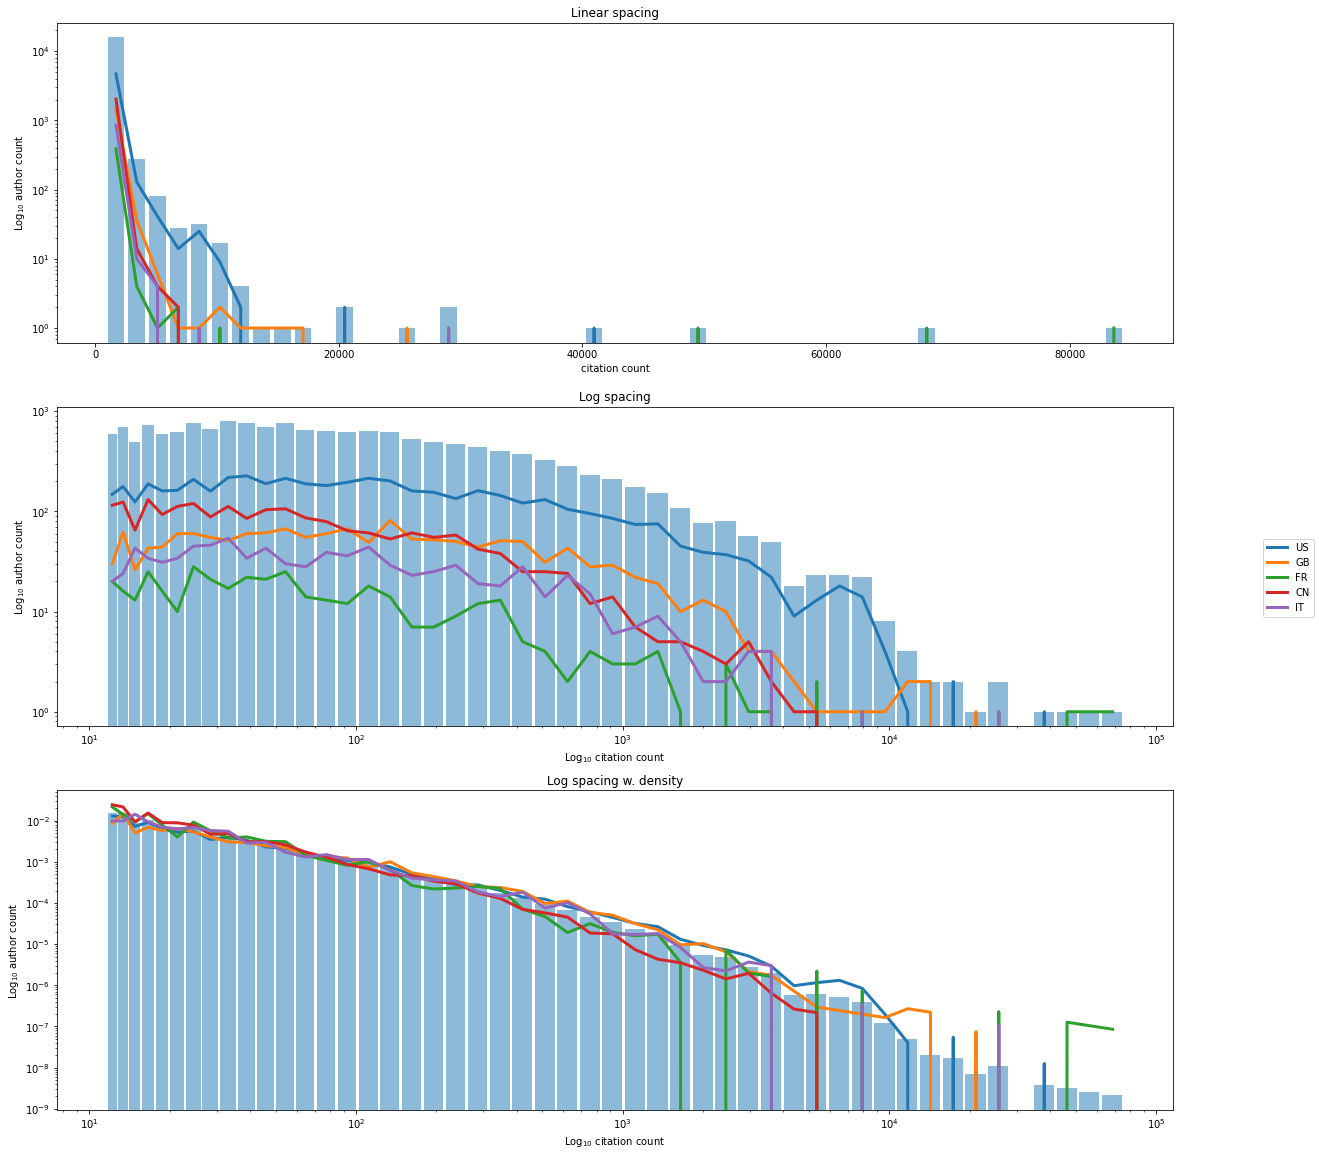

In [11]:
# Q2
citation_count = citation_df.citation_count[citation_df.citation_count > 0]

fig,ax = plt.subplots(3,1,figsize=(20,20))

# Linear
linbins = np.linspace(min(citation_count),
                      max(citation_count),50)
hist, edges = np.histogram(citation_count,bins=linbins)
xlin = (edges[:-1]+edges[1])/2 # get midpoints between edges
width = linbins[1:]-linbins[:-1] # 

ax[0].bar(xlin,hist,width=width*0.4,alpha=0.5)
ax[0].set_xlabel("citation count")
ax[0].set_ylabel("Log$_{10}$ author count")
ax[0].set_yscale("log")
ax[0].set_title("Linear spacing")

# Log
logbins = np.logspace(np.log10(min(citation_count)),
                      np.log10(max(citation_count)),50)
hist, edges = np.histogram(citation_count,bins=logbins)
xlog = (edges[:-1]+edges[1])/2 # get midpoints between edges
width = logbins[1:]-logbins[:-1] # 

ax[1].bar(xlog,hist,width=width*0.4,alpha=0.5)
ax[1].set_xlabel("Log$_{10}$ citation count")
ax[1].set_ylabel("Log$_{10}$ author count")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_title("Log spacing")

# Log density
hist, edges = np.histogram(citation_count,bins=logbins, density=True)

ax[2].bar(xlog,hist,width=width*0.4,alpha=0.5)
ax[2].set_xlabel("Log$_{10}$ citation count")
ax[2].set_ylabel("Log$_{10}$ author count ")
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_title("Log spacing w. density")

# Q3
top_cc = citation_df.groupby("last_country_code")["citation_count"].sum().sort_values(ascending=False)[:5].index
for country in top_cc:
    country_count = citation_df[citation_df.last_country_code == country]["citation_count"]
    hist_c, _ = np.histogram(country_count,bins=linbins)
    ax[0].plot(xlin,hist_c, label=country,linewidth=3)
    
    hist_c, _ = np.histogram(country_count,bins=logbins)
    ax[1].plot(xlog,hist_c, label=country,linewidth=3)
    
    hist_c, _ = np.histogram(country_count,bins=logbins, density=True)
    ax[2].plot(xlog,hist_c, label=country,linewidth=3)
fig.legend(top_cc,loc="right")
plt.show()

# Q4
# As can be seen on the plot below, the linear spacing has a lot of gaps due to some authors having extremely 
# high citation count. As such it's hard to inference any relationships

# Q5
# 

# Q6

# Week 4

In [12]:
# P1
full_paper = pd.read_pickle("full_df_paper.pickle")
order = lambda x,y: (min(x,y),max(x,y))

wedge = {}
for collab in full_paper.author_ids:
    for i in range(len(collab)):
        for j in range(i+1,len(collab)):
            pair = order(collab[i],collab[j])
            wedge[pair] = wedge.get(pair,0) + 1

# full_paper
# wedge

# P2 
G = nx.Graph()
for key,val in wedge.items():
    G.add_edge(*key, weight=val)

# P3
full_author = pd.read_pickle("full_df_researchers.pickle")
full_paper  = pd.read_pickle("full_df_paper.pickle")

full_author.insert(4,"citation_count",0)
full_author.insert(5,"first_publish",9999)
for count,pyear,authors in tqdm(full_paper[["cited_by_count","publication_year","author_ids"]].iloc,total=len(full_paper)):
    for author in authors:
        full_author.citation_count[full_author.id==author] += count
        if full_author["first_publish"][full_author.id==author].iloc[0] > pyear:
            full_author["first_publish"][full_author.id==author] = pyear

full_author.first_publish = full_author.first_publish.replace(9999,None)
full_author = full_author.rename(columns={"last_country_code":"country"})
node_attr = full_author[["id","display_name","country","first_publish"]].set_index('id').to_dict("index")
nx.set_node_attributes(G, node_attr)

from networkx.readwrite import json_graph
import json
with open('graph.json', 'w') as f:
    json.dump(json_graph.node_link_data(G), f)
# json_graph.node_link_data(G)

  0%|          | 0/31679 [00:00<?, ?it/s]c:\Users\son22\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)
100%|██████████| 31679/31679 [03:29<00:00, 151.41it/s]


In [13]:
# Net metric
print(G.number_of_nodes())
print(G.number_of_edges())
print(G.number_of_edges()/sum(range(G.number_of_nodes()))) # 
print(len(list(nx.connected_components(G))))
print(nx.number_of_isolates(G))

16286
60284
0.00045460045228537136
108
0


In [14]:
# Degree analysis
deg_df = pd.DataFrame(list(G.degree()),columns=["id","Node degree"])
print(deg_df.describe())
print(deg_df.value_counts().idxmax()) # mode

wgt_df = pd.DataFrame([w["weight"] for _,_,w in G.edges(data=True)],columns=["Node weights"])
print(wgt_df.describe())
print(wgt_df.value_counts().idxmax()) # mode

        Node degree
count  16286.000000
mean       7.403168
std        9.162380
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max      229.000000
('A5000005989', 5)
       Node weights
count  60284.000000
mean       1.720788
std        2.141256
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       85.000000
(1,)


In [15]:
# Top authors
top_authors = list(deg_df.sort_values(by="Node degree",ascending=False)[:5].id)

for ta in top_authors:
    print(ta,G.nodes[ta])

A5052134746 {'display_name': 'Yuan Chen', 'country': 'CN', 'first_publish': 1994}
A5088141761 {'display_name': 'Jonathan D. Cohen', 'country': 'IT', 'first_publish': 1990}
A5036031567 {'display_name': 'Miao Zhang', 'country': 'CN', 'first_publish': 2000}
A5044944954 {'display_name': 'Lyle H. Ungar', 'country': 'US', 'first_publish': 1988}
A5017914184 {'display_name': 'Stephan Lewandowsky', 'country': 'AU', 'first_publish': 1983}


### Ex 2

In [17]:
G_sub = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
visualize(G_sub)

(None, None)